<a href="https://colab.research.google.com/github/MarioMarkov/cars_predict_web/blob/master/cars_predict_tf_tidy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Load libraries
import pandas as pd 
import tensorflow as tf
import numpy as np

pd.options.display.float_format = '{:.10f}'.format

In [ ]:
#@title Load data
data = pd.read_csv('/content/drive/MyDrive/cars_predict/cars-data3.csv', index_col=None)
test_pred = pd.read_csv('/content/drive/MyDrive/cars_predict/test-data.csv',  index_col=None)

data = data.drop(['id'],axis='columns')

data = data.drop(['euro'],axis='columns')
test_pred = test_pred.drop(['euro'],axis='columns')

In [ ]:
#@title Clean data 🧹 

print("Old Shape before cleaning: ", data.shape)

def clean_data(data):

  # Remove brands that are seen less than 200 times
  data = data.groupby('brand').filter(lambda x :len(x)>200)

  #Format BMW model
  def format_bmw_model(model_name):
    if 'X' in model_name or 'i' in model_name:
      return model_name
    return model_name[0]

  # Trim model to just 1 letter except if it is X or i ex.(318 to 3)
  data.loc[data['brand'] == 'BMW', ['model']] = data[data.brand == 'BMW'].model.apply(lambda x: format_bmw_model(x))

  # Remove models that are met less than 9 times
  data = data.groupby('model').filter(lambda x :len(x)>20)

  # Remove years that are met less than 10 times
  data = data.groupby('year').filter(lambda x :len(x)>10)

  #data.dropna(how="any", axis=0, inplace=True)

  # TODO this removes missing values 
  data = data[(data.hp >30) & (data.hp < 480)]
  data = data[(data.price >100) & (data.price < 60000)]
  data = data[(data.displacement >100) & (data.displacement < 8000)]
  data = data[(data.kms >100) & (data.kms < 1000000)]
  data = data.dropna()

  return data 

# Applying function
data = clean_data(data)

print("New Shape after cleaning: ", data.shape)

# Put a flag on premium brands
premium_brands = ["Porsche", "Audi","Mercedes-Benz","BMW"]

data['premium'] = np.where(data['brand'].isin(premium_brands), 1, 0)
test_pred['premium'] = np.where(test_pred['brand'].isin(premium_brands), 1, 0)

# data['new'] = np.where(data['year']>2018, 1, 0)
# test_pred['new'] = np.where(test_pred['year']>2018, 1, 0)

def make_buckets(df):
  bins = [0,50000, 100000, 150000,200000,250000,300000,400000,500000,600000]
  labels = [1,2,3,4,5,6,7,8,9]
  df['kms'] = pd.cut(x = df['kms'], 
                     bins = bins,
                     labels = labels,
                     include_lowest = True)
  return df
data = make_buckets(data)
test = make_buckets(test_pred)
data = data.dropna()

data["kms"] = data["kms"].astype("int32")
test["kms"] = test["kms"].astype("int32")

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# Select columns with 'float64' dtype  
numeric_cols = list(data.select_dtypes(include=numerics))

# The same code again calling the columns
data[numeric_cols] = data[numeric_cols].astype('float32')


print(data.describe())

# How many missing values per column 
(data.isnull().sum())
data.to_csv('cars-data_index.csv', index=True)

Old Shape before cleaning:  (25670, 12)
New Shape after cleaning:  (18799, 12)


<ipython-input-66-0768fa38a36b>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["kms"] = data["kms"].astype("int32")
<ipython-input-66-0768fa38a36b>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[numeric_cols] = data[numeric_cols].astype('float32')


                  year              kms     transmission            2door  \
count 18795.0000000000 18795.0000000000 18795.0000000000 18795.0000000000   
mean   2008.2409667969     4.2332005501     0.2551210523     0.0824155360   
std       4.9047985077     1.1936763525     0.4359408319     0.2750040591   
min    1990.0000000000     1.0000000000     0.0000000000     0.0000000000   
25%    2005.0000000000     4.0000000000     0.0000000000     0.0000000000   
50%    2008.0000000000     4.0000000000     0.0000000000     0.0000000000   
75%    2011.0000000000     5.0000000000     1.0000000000     0.0000000000   
max    2022.0000000000     9.0000000000     1.0000000000     1.0000000000   

          displacement               hp            price          premium  
count 18795.0000000000 18795.0000000000 18795.0000000000 18795.0000000000  
mean   1906.8477783203   131.0482635498 11497.6367187500     0.1308326721  
std     577.5339355469    49.3135643005  9097.5136718750     0.3372262418  
mi

In [ ]:
#@title Define helper Functions

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('price')
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = tf.keras.layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)
  return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = tf.keras.layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = tf.keras.layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = tf.keras.layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))


In [ ]:
#@title Making tf-dataset
# Split data
train, val, test = np.split(data.sample(frac=1), [int(0.9*len(data)), int(0.95*len(data))])

print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

16915 training examples
940 validation examples
940 test examples


<ipython-input-67-35e913b20012>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
<ipython-input-67-35e913b20012>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
<ipython-input-67-35e913b20012>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [ ]:
#@title Tensorflow preprocessing

# Normalize numerical features
all_inputs = []
encoded_features = []
columns_to_normalize = ['year','displacement','hp','kms']

[(train_features, label_batch)] = train_ds.take(1)

for header in columns_to_normalize:
  # Input for feature
  numeric_col = tf.keras.Input(shape=(1,), name=header)

  # Normalization layer for feature
  normalization_layer = get_normalization_layer(header, train_ds)

  # Normalizes feature
  encoded_numeric_col = normalization_layer(numeric_col)

  # Appends to all feature
  all_inputs.append(numeric_col)

  # Appends to encoded features
  encoded_features.append(encoded_numeric_col)


# Encode zero-one variables
transmission_col = tf.keras.Input(shape=(1,), dtype='int64',name= "transmission")
col_2door = tf.keras.Input(shape=(1,), dtype='int64',name= "2door")
premium_col = tf.keras.Input(shape=(1,), dtype='int64',name= "premium")
new_col = tf.keras.Input(shape=(1,), dtype='int64',name= "new")

encoding_layer_transmission = get_category_encoding_layer(name='transmission',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=2)

encoding_layer_door2 = get_category_encoding_layer(name='2door',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=2)
encoding_layer_premium = get_category_encoding_layer(name='premium',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=2)
# encoding_layer_new = get_category_encoding_layer(name='new',
#                                              dataset=train_ds,
#                                              dtype='int64',
#                                              max_tokens=2)

#Transmission
encoded_transmission_col = encoding_layer_transmission(transmission_col)

# Door w
encoded_door2_col = encoding_layer_door2(col_2door)

# Premium
encoded_premium_col = encoding_layer_premium(premium_col)

# New
#encoded_new_col = encoding_layer_new(new_col)


all_inputs.extend([transmission_col, col_2door, premium_col,
                   #new_col 
                   ])

encoded_features.extend([encoded_transmission_col,encoded_door2_col,
                         encoded_premium_col,
                         #encoded_new_col, 
                         ])


# Encode string variables
categorical_cols = ['brand', 'model','type','color','fuel']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  tokens = len(train[header].unique())
  print(header, tokens)
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=tokens)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


all_features = tf.keras.layers.concatenate(encoded_features)


brand 29
model 219
type 8
color 20
fuel 6


In [ ]:
#@title Define model

initializer = tf.keras.initializers.HeNormal(seed = 42)

x_1 = tf.keras.layers.Dense(500, activation="relu",kernel_initializer=initializer,
                            bias_initializer='zeros')(all_features)
                            
x_2 = tf.keras.layers.Dense(300, activation="relu",kernel_initializer=initializer,
    bias_initializer='zeros')(x_1)

x_3 = tf.keras.layers.Dense(200, activation="relu",kernel_initializer=initializer,
    bias_initializer='zeros')(x_2)
#x_3 = tf.keras.layers.Dropout(0.5)(x_2)

output = tf.keras.layers.Dense(1,kernel_initializer=initializer,
    bias_initializer='zeros')(x_3)

model = tf.keras.Model(all_inputs, output)

loss_fn = tf.keras.losses.Huber()


# initial_learning_rate = 0.01
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=250,
#     decay_rate=0.95,
#     staircase=True)

def scheduler(epoch, lr):
  if epoch < 7:
    return 0.01
  elif epoch >=8 and epoch <=15: return 0.003
  else:
    return 0.001

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = tf.keras.optimizers.Adam()
lr_metric = get_lr_metric(optimizer)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(train_ds, epochs=25, validation_data=val_ds, callbacks=[callback])

print("Evaluation error: ", model.evaluate(test_ds, verbose=2))

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['price'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


265/265 [==============================] - 10s 22ms/step - loss: 2771.2344 - root_mean_squared_error: 4815.8140 - val_loss: 2005.9093 - val_root_mean_squared_error: 2960.1599 - lr: 0.0100
Epoch 2/25
265/265 [==============================] - 4s 13ms/step - loss: 1890.7770 - root_mean_squared_error: 2955.4526 - val_loss: 1848.2769 - val_root_mean_squared_error: 2826.2314 - lr: 0.0100
Epoch 3/25
265/265 [==============================] - 4s 13ms/step - loss: 1804.7808 - root_mean_squared_error: 2791.5017 - val_loss: 1830.3649 - val_root_mean_squared_error: 2717.0254 - lr: 0.0100
Epoch 4/25
265/265 [==============================] - 6s 21ms/step - loss: 1755.1027 - root_mean_squared_error: 2723.6440 - val_loss: 1744.4296 - val_root_mean_squared_error: 2669.5679 - lr: 0.0100
Epoch 5/25
265/265 [==============================] - 4s 14ms/step - loss: 1757.6927 - root_mean_squared_error: 2724.0330 - val_loss: 1703.4587 - val_root_mean_squared_error: 2618.5037 - lr: 0.0100
Epoch 6/25
265/265 [

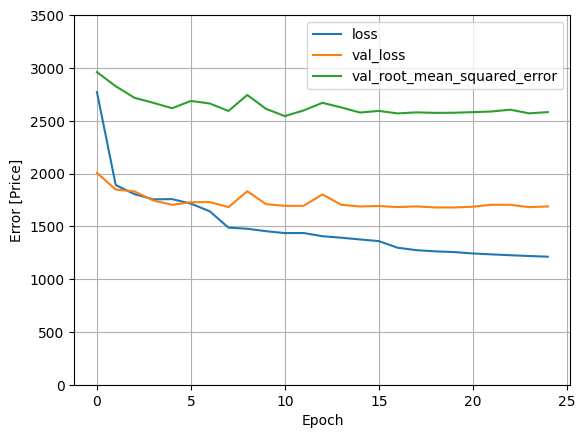

In [ ]:
import matplotlib.pyplot as plt
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.plot(history.history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Price]')
  plt.legend()
  plt.ylim(0, 3500)
  plt.grid(True)
  plt.show()

plot_loss(history)

In [ ]:
from google.colab import files

#saved_model = tf.keras.models.load_model('/content/drive/MyDrive/cars_predict/saved_model_new_tf/my_model')

sample = {
    'brand': 'Opel',
    'model': 'Corsa',
    'year': 1999,
    'type': 'hatchback',
    'color': 'white',
    'kms': 7,
    'transmission': 0,
    '2door': 0,
    'displacement': 1400,
    'hp': 60,
    'premium': 0,
    'fuel': 'p'
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)
#pd.options.display.float_format = '{:.15f}'.format
print(type(input_dict))
print(predictions[0][0])


1/1 [==============================] - 1s 965ms/step
<class 'dict'>
1899.4023


In [ ]:
# Save and download model
model.save('/content/drive/MyDrive/cars_predict/saved_model_new_tf/my_model')
#files.download("/content/saved_model")